## Model based clustering


In [8]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import joblib

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from pycytominer import normalize
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.cluster import KMeans


from  inputs.em_clustering_with_init import EM_model

In [17]:
## as this file is very big, you need to have it separetlyin your sytem, add it to vs code when needed andthen delete i to be able to commit the code
axiom_data= pd.read_csv('../01.data/inputs/2rep_4cpds.csv')

### Feature selection

In [ ]:
def remove_low_variance_features(df, threshold):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df)
    return df[df.columns[selector.get_support(indices=True)]]

def remove_correlated_features(df, correlation_threshold=0.95):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    return df.drop(columns=to_drop)

def remove_redundant_features(df):
    return df.loc[:, ~df.columns.duplicated()]


# without metadata
columns_to_drop = ['FileName_CellOutlines','TableNumber', 'ImageNumber', 'ObjectNumber', 'well', 'name', 'plate', 'replicate', 'concentration']  
fd= axiom_data.drop(columns=columns_to_drop)



df2 = remove_low_variance_features(fd, threshold=0.01)
df2 = remove_correlated_features(df2, correlation_threshold=0.95)
df2 = remove_redundant_features(df2)

print(df2.head())


In [10]:
metadata = axiom_data[columns_to_drop]
df2_with_metadata = pd.concat([df2, metadata], axis=1)

print(df2_with_metadata.head())

   Cells_AreaShape_Area  Cells_AreaShape_BoundingBoxArea  \
0                 49112                            93074   
1                 42042                            80433   
2                 49791                            72962   
3                 30959                            42048   
4                 36302                            60310   

   Cells_AreaShape_BoundingBoxMaximum_X  Cells_AreaShape_BoundingBoxMaximum_Y  \
0                                  2085                                   269   
1                                  1556                                   243   
2                                  1299                                   191   
3                                  1900                                   192   
4                                  1471                                   282   

   Cells_AreaShape_Compactness  Cells_AreaShape_Eccentricity  \
0                     3.280391                      0.832728   
1                     3.

In [ ]:
unique_plates = df2_with_metadata['plate'].unique()

normalized_dfs = []


for plate in unique_plates:

    plate_data = df2_with_metadata[df2_with_metadata['plate'] == plate]
    normalized_plate = normalize(
        profiles=plate_data,
        features="infer",  
        image_features=False,
        meta_features=['TableNumber', 'ImageNumber', 'ObjectNumber', 'name', 'plate', 'replicate', 'well', 'concentration'],
        samples="name == 'DMSO' ",  
        method="mad_robustize"
    )
    

    normalized_dfs.append(normalized_plate)


normalized_df = pd.concat(normalized_dfs, ignore_index=True)


### Applied EM

In [ ]:
n_well= normalized_df['well'].nunique()

columns_to_drop = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'well', 'name', 'plate', 'replicate', 'concentration']  
fd= normalized_df.drop(columns=columns_to_drop)

scaler = StandardScaler()

data_stand = scaler.fit_transform(fd)

em = EM_model(X=data_stand, n_well=n_well)

# Test K = 2 à 6
icl_scores, optimal_K = em.find_optimal_K_by_icl(K_values=range(2, 7), n_init=10)


mu, Sigma, pi, alpha, icl = em.run_em_for_K(optimal_K, n_init=10)

In [ ]:
np.random.seed(42)

def initialize_parameters(X, K):
 
    n_samples, n_features = X.shape


    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    mu = kmeans.cluster_centers_

    pi = np.array([np.mean(labels == k) for k in range(K)])

    Sigma = np.zeros((K, n_features, n_features))
    for k in range(K):
        cluster_points = X[labels == k]
        if len(cluster_points) > 1:
            Sigma[k] = np.cov(cluster_points, rowvar=False)
        else:
            Sigma[k] = np.eye(n_features)

    return mu, Sigma, pi




def regularize_covariance(cov, epsilon=1e-6):
    return cov + np.eye(cov.shape[0]) * epsilon

def e_step(X, mu, Sigma, pi):
    n_samples, n_features = X.shape
    K = len(pi)
    log_alpha = np.zeros((n_samples, K))
    
    for k in range(K):
        cov_matrix = regularize_covariance(Sigma[k])
        
        rv = multivariate_normal(mean=mu[k], cov=cov_matrix, allow_singular=True)
        
        log_pdf_values = rv.logpdf(X)
        
        log_alpha[:, k] = np.log(pi[k]) + log_pdf_values

    log_alpha_max = np.max(log_alpha, axis=1, keepdims=True)
    log_alpha -= log_alpha_max
    alpha = np.exp(log_alpha)
    
    alpha_sum = alpha.sum(axis=1)[:, np.newaxis]
    alpha_sum = np.maximum(alpha_sum, 1e-10)
    alpha /= alpha_sum

    if np.any(np.isnan(alpha)) or np.any(np.isinf(alpha)):
        raise ValueError("Alpha contains invalid values.")
    
    return alpha


def m_step(X, alpha):
    n_samples, n_features = X.shape
    K = alpha.shape[1]
    Nk = alpha.sum(axis=0)

    pi = Nk / n_samples
    pi = np.maximum(pi, 1e-10)
    pi /= np.sum(pi)

    mu = np.dot(alpha.T, X) / Nk[:, np.newaxis]

    Sigma = np.zeros((K, n_features, n_features))

    for k in range(K):
        diff = X - mu[k]
        poids = alpha[:, k][:, np.newaxis] * diff
        poids = np.dot(poids.T, diff)
        diag_covariance = np.diag(poids) / Nk[k]
        Sigma[k] = np.diag(diag_covariance)
        
        # Vérification de la matrice de covariance
        if np.any(np.isnan(Sigma[k])) or np.any(np.isinf(Sigma[k])):
            print(f"Invalid values in covariance matrix for cluster {k}")
    
    return mu, Sigma, pi


def log_likelihood(X, mu, Sigma, pi):
    n_samples = X.shape[0]
    n_clusters = len(pi)
    densities = []

    for k in range(n_clusters):
        try:
            densities.append(multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]))
        except np.linalg.LinAlgError:
           
            Sigma[k] += np.eye(len(Sigma[k])) #* 1e-6  # Small regularization
            densities.append(multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]))

    densities = np.array(densities).T
    weighted_densities = densities * pi
    ll = np.sum(np.log(np.sum(weighted_densities, axis=1) + 1e-10))

    return ll




def log_likelihood_complete(X, mu, Sigma, pi, alpha):
    log_densities = np.array([multivariate_normal.logpdf(X, mean=mu[k], cov=Sigma[k]) for k in range(len(pi))]).T
    weighted_log_densities = alpha * (np.log(pi) + log_densities)
    ll_comp = np.sum(weighted_log_densities)
    return ll_comp





## EM sans les critères
def em_algorithm(X, K, max_iter=100, tol=1e-4):
    mu, Sigma, pi = initialize_parameters(X, K)
    log_likelihoods = []

    for iteration in range(max_iter):
        alpha = e_step(X, mu, Sigma, pi)
        mu, Sigma, pi = m_step(X, alpha)
        ll = log_likelihood_complete(X, mu, Sigma, pi, alpha)  
        log_likelihoods.append(ll)


        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return mu, Sigma, pi, alpha



def find_best_initialization(X_ref, K, n_init=7, max_iter=20, tol=1e-3):
    best_ll_complete = -np.inf
    best_params = None
    for init in range(n_init):
        try:
            mu, Sigma, pi = initialize_parameters(X_ref, K)
            mu_est, Sigma_est, pi_est, alpha_est = em_algorithm(
                X_ref, K, max_iter=max_iter, tol=tol
            )
            ll_complete = log_likelihood_complete(X_ref, mu_est, Sigma_est, pi_est, alpha_est)
            if ll_complete > best_ll_complete:
                best_ll_complete = ll_complete
                best_params = {"mu": mu_est, "Sigma": Sigma_est, "pi": pi_est}
        except Exception as e:
            print(f"Initialization {init + 1}/{n_init} failed: {e}")
    if best_params is None:
        raise ValueError("No valid initialization was found. Please check your data or initialization method.")
    return best_params

def em_algorithm_with_best_init(X, K, max_iter=10, tol=1e-3):
    try:
        best_params = find_best_initialization(X, K)
    except ValueError as e:
        print(e)
        return None, None, None, None
    
    mu, Sigma, pi = best_params["mu"], best_params["Sigma"], best_params["pi"]
    n_samples, n_features = X.shape
    log_likelihoods = []
    for iteration in range(max_iter):
        alpha = e_step(X, mu, Sigma, pi)
        mu, Sigma, pi = m_step(X, alpha)
        ll = log_likelihood(X, mu, Sigma, pi)
        ll_comp = log_likelihood_complete(X, mu, Sigma, pi, alpha)
        log_likelihoods.append(ll)
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    return mu, Sigma, pi, alpha



columns_to_drop = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'well', 'name', 'plate', 'replicate', 'concentration']  
fd= normalized_df.drop(columns=columns_to_drop)


pca = PCA(n_components=50)  
principal_components = pca.fit_transform(fd)


pca_df = pd.DataFrame(data=principal_components)
#print(pca_df.head())

scaler = StandardScaler()
data_stand = scaler.fit_transform(pca_df)

mu, Sigma, pi, alpha = em_algorithm_with_best_init(data_stand, 6)
print("Means:", mu)
print("Covariances:", Sigma)
print("Proportions:", pi)



Means: [[ 7.23746149e-01  4.08920662e-02 -6.16135614e-02  3.96636616e-02
  -6.81688536e-02 -1.15522914e-01  6.96038878e-02  4.33018864e-02
   1.46688790e-02  7.42300606e-02 -5.43232437e-03  2.63356144e-03
   7.74049819e-02 -2.66488771e-03 -1.09721823e-01  1.51650674e+00
  -2.16302807e-02 -8.50437134e-02  2.12798687e-02 -6.41300081e-04
  -5.62297412e-02  2.87530192e-02 -1.51661374e-02 -4.37199984e-03
   1.63655839e-01  2.87242915e-01 -8.91862424e-02  1.47540943e-01
   8.68809841e-02 -3.19935656e-02 -4.64520839e-02 -3.36359954e-03
   3.90037685e-03 -1.34057339e-02  1.82960024e-01  1.34484005e-02
  -6.91179871e-02  2.57297251e-01  2.01508658e-01 -1.17890826e-02
  -4.51528748e-01  6.02276206e-03 -7.47331182e-04 -1.97062480e-01
  -6.96974066e-01  4.62742714e-01  6.19907508e-01 -6.27041744e-01
  -5.94121642e-01 -6.63109955e-01]
 [-1.42470406e-01  8.76927441e-02  4.75554467e-01  2.87903593e-03
  -1.42378092e-02  5.06182559e-02 -1.01394785e-02 -2.65101224e-02
   7.78864661e-05  6.56859305e-03 

In [35]:
def compute_icl(X, num_param, log_likelihood_comp):
    n_samples = X.shape[0]
    return (-2) * log_likelihood_comp + np.log(n_samples) * num_param



# Algorithme EM avce calcule des critères 
def em_algorithm_crit(X, K, n_well, max_iter=100, tol=1e-6):
    mu, Sigma, pi = initialize_parameters(X, K)
    n_samples, n_features = X.shape
    log_likelihoods = []

    for iteration in range(max_iter):
        alpha = e_step(X, mu, Sigma, pi)  
        mu, Sigma, pi = m_step(X, alpha)  
        
        ll = log_likelihood(X, mu, Sigma, pi) 
        ll_comp = log_likelihood_complete(X, mu, Sigma, pi, alpha) 
        
        log_likelihoods.append(ll)
        
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    num_param = 2*K * n_features + (K-1)*n_well
    icl = compute_icl(X, num_param, ll_comp)

    print(f"K={K}, Log-likelihood={ll:.2f}, Log-likelihood Complete={ll_comp:.2f}, Num Params={num_param}, ICL={icl:.2f}")

    return mu, Sigma, pi, alpha, icl

n_well= normalized_df['well'].nunique()

K_values = range(2, 7)
icl_scores = []


for K in K_values:
    _, _, _, _, icl = em_algorithm_crit(data_stand, K, n_well)
    icl_scores.append(icl)


optimal_K_icl = K_values[np.argmin(icl_scores)]

print(f"Optimal K based on ICL: {optimal_K_icl}")





K=2, Log-likelihood=-2256464.31, Log-likelihood Complete=-112551171.09, Num Params=3457, ICL=225142072.41
K=3, Log-likelihood=-2256464.31, Log-likelihood Complete=-102509485.98, Num Params=5234, ICL=205079124.71
K=4, Log-likelihood=-2256464.31, Log-likelihood Complete=-100280990.61, Num Params=7011, ICL=200642556.48
K=5, Log-likelihood=-2256464.31, Log-likelihood Complete=-98526843.10, Num Params=8788, ICL=197154683.98
K=6, Log-likelihood=-2256464.31, Log-likelihood Complete=-96951765.27, Num Params=10565, ICL=194024950.83
Optimal K based on ICL: 6


In [ ]:
# save the EM parameters

joblib.dump({'mu': mu, 'Sigma': Sigma, 'pi': pi, 'alpha': alpha}, 'em_parameters.pkl')
params = joblib.load('em_parameters.pkl')

mu_loaded = params['mu']
Sigma_loaded = params['Sigma']
pi_loaded = params['pi']
alpha_loaded = params['alpha']


In [59]:
print(axiom_data['name'].unique())

['DMSO' 'Celecoxib' 'Ketoprofen' 'Mefenamic acid' 'Lumiracoxib']


### Graph of results

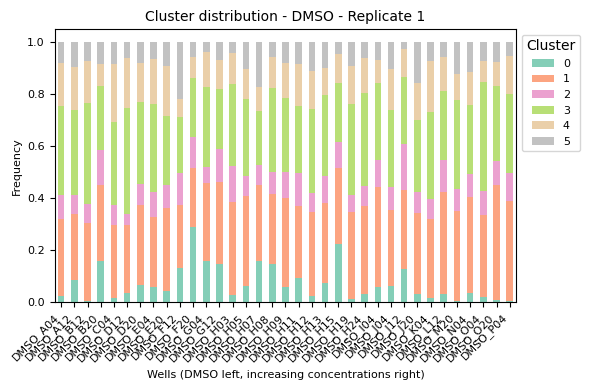

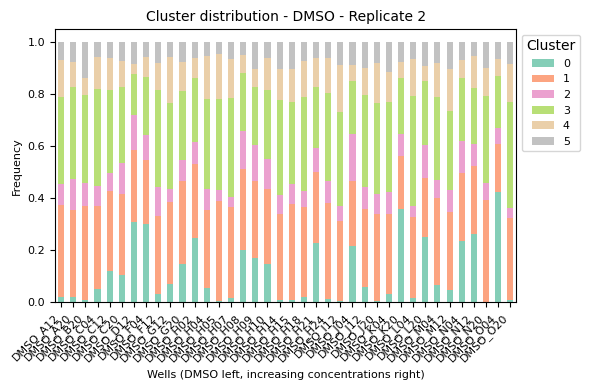

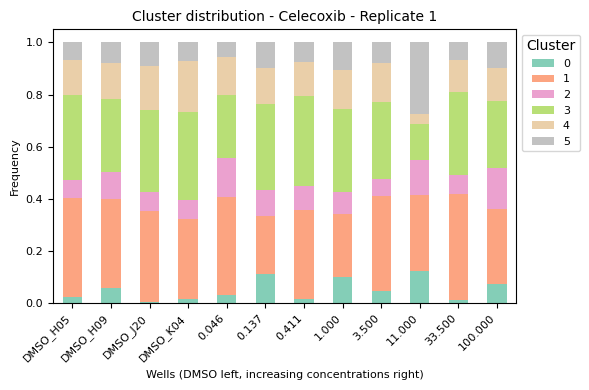

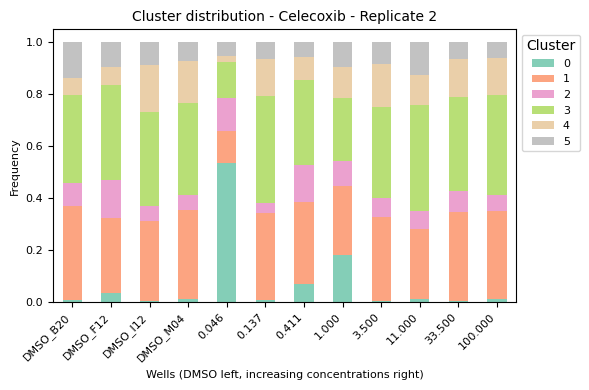

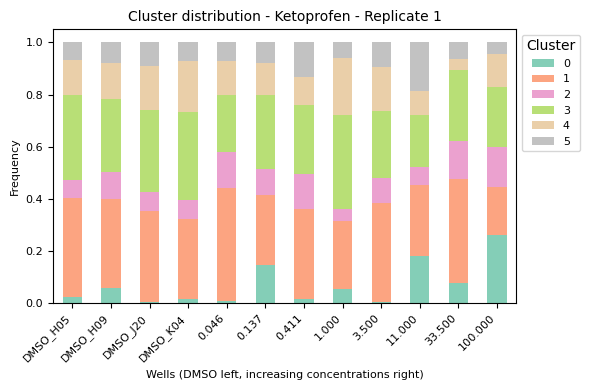

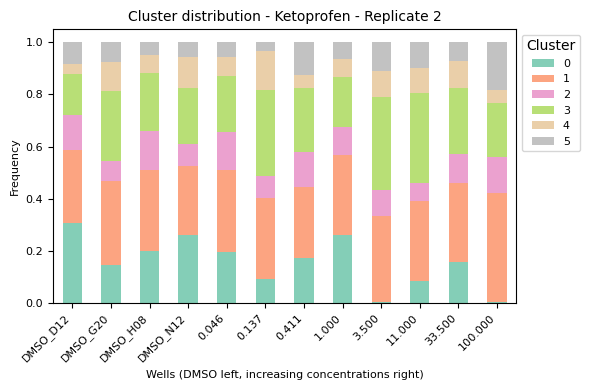

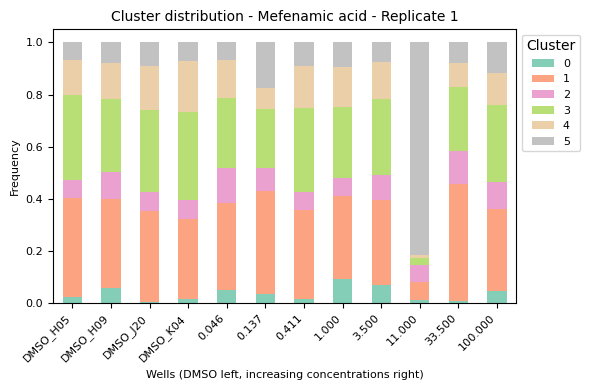

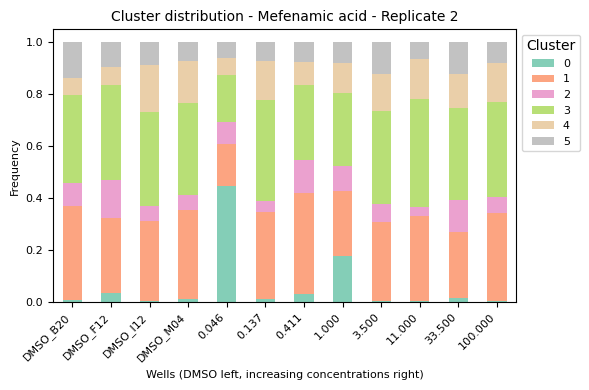

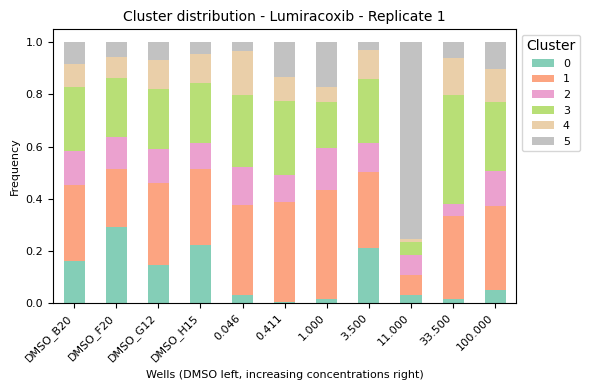

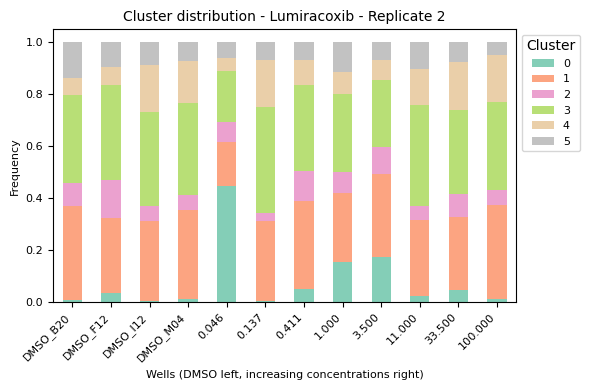

In [19]:
params = joblib.load('./outputs/em_parameters.pkl')


mu = params['mu']
Sigma = params['Sigma']
pi = params['pi']
alpha = params['alpha']

df = pd.DataFrame({
    'Cluster': np.argmax(alpha, axis=1),
    'Compound': axiom_data['name'],
    'Concentration': axiom_data['concentration'].round(3),
    'Well': axiom_data['well'],
    'Replicate': axiom_data['replicate'],
    'Plate': axiom_data['plate']
})

compound_name = axiom_data['name'].unique()

for compound in compound_name:
    compound_data = df[df['Compound'] == compound]
    replicates = compound_data['Replicate'].unique()

    for replicate in replicates:
        replicate_data = compound_data[compound_data['Replicate'] == replicate]
        plate_id = replicate_data['Plate'].iloc[0]

        dmsos_same_plate = df[(df['Compound'] == 'DMSO') & (df['Plate'] == plate_id)]

        combined_data = pd.concat([dmsos_same_plate, replicate_data], ignore_index=True)

        combined_data['SampleID'] = combined_data.apply(
            lambda row: f"DMSO_{row['Well']}" if row['Compound'] == 'DMSO' 
            else f"{row['Concentration']:.3f}", axis=1
        )

        cluster_freqs = combined_data.groupby(['SampleID', 'Cluster']).size().unstack(fill_value=0)
        cluster_freqs = cluster_freqs.div(cluster_freqs.sum(axis=1), axis=0)

        dmso_ids = [idx for idx in cluster_freqs.index if idx.startswith('DMSO')]
        conc_ids = sorted([idx for idx in cluster_freqs.index if not idx.startswith('DMSO')], key=lambda x: float(x))
        ordered_index = dmso_ids + conc_ids
        cluster_freqs = cluster_freqs.loc[ordered_index]

        plt.figure(figsize=(6,4))
        cluster_freqs.plot(kind='bar', stacked=True, colormap='Set2', alpha=0.8, ax=plt.gca())

        plt.title(f"Cluster distribution - {compound} - Replicate {replicate}", fontsize=10)
        plt.ylabel("Frequency", fontsize=8)
        plt.xlabel("Wells (DMSO left, increasing concentrations right)", fontsize=8)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.legend(title="Cluster", fontsize=8, bbox_to_anchor=(1, 1), loc="upper left")
        plt.tight_layout()
        plt.show()


In [21]:
# table of cluster proportions
params = joblib.load('./outputs/em_parameters.pkl')
alpha = params['alpha']

df = pd.DataFrame({
    'Cluster': np.argmax(alpha, axis=1),
    'Compound': axiom_data['name'],
    'Concentration': axiom_data['concentration'].round(3),
    'Well': axiom_data['well'],
    'Replicate': axiom_data['replicate'],
    'Plate': axiom_data['plate']
})


summary_rows = []

compound_names = df['Compound'].unique()

for compound in compound_names:
    compound_data = df[df['Compound'] == compound]
    replicates = compound_data['Replicate'].unique()

    for replicate in replicates:
        replicate_data = compound_data[compound_data['Replicate'] == replicate]
        plate_id = replicate_data['Plate'].iloc[0]

        dmsos_same_plate = df[(df['Compound'] == 'DMSO') & (df['Plate'] == plate_id)]

        combined_data = pd.concat([dmsos_same_plate, replicate_data], ignore_index=True)

        combined_data['SampleID'] = combined_data.apply(
            lambda row: f"DMSO_{row['Well']}" if row['Compound'] == 'DMSO'
            else f"{compound}_Rep{row['Replicate']}_Conc{row['Concentration']:.3f}", axis=1
        )

        cluster_freqs = combined_data.groupby(['SampleID', 'Cluster']).size().unstack(fill_value=0)
        cluster_freqs = cluster_freqs.div(cluster_freqs.sum(axis=1), axis=0)  # proportions

    
        cluster_freqs['Compound'] = compound
        cluster_freqs['Replicate'] = replicate


        cluster_cols = [col for col in cluster_freqs.columns if isinstance(col, int)]
        cluster_cols_sorted = [f'Cluster {k}' for k in sorted(cluster_cols)]
        cluster_freqs.columns = [f'Cluster {col}' if isinstance(col, int) else col for col in cluster_freqs.columns]

 
        ordered_cols = ['Compound', 'Replicate'] + cluster_cols_sorted
        cluster_freqs = cluster_freqs.reset_index()[['SampleID'] + ordered_cols]

        summary_rows.append(cluster_freqs)


result_table = pd.concat(summary_rows, ignore_index=True)


In [ ]:
result_table.to_csv("./outputs/cluster_proportions.csv", index=False)

### Permutation tests

In [22]:
cluster_results= pd.read_csv('./outputs/cluster_proportions.csv')

In [31]:

# on extrait la proportion de chaque puit 
cluster_freq = df.groupby(['Replicate', 'Plate', 'Compound', 'Well', 'Concentration'])['Cluster'].value_counts(normalize=True).unstack(fill_value=0)



tab1= cluster_freq.loc[1]
tab2= cluster_freq.loc[2]



rep1 = pd.DataFrame(tab1)
rep1 = rep1.reset_index()

rep2 = pd.DataFrame(tab2)
rep2 = rep2.reset_index()


rep1['Replicate'] = '1'
rep2['Replicate'] = '2'


In [ ]:
tabs = [rep1, rep2]  # Réplicats

nrep = 10000  

observed_stats = {}
permuted_stats = {}



K = 6
columns_to_select = list(range(K)) 

observed_stats = {}  
permuted_stats = {}  

nrep = 10000  

for tab in tabs:
    unique_concentrations = tab["Concentration"].unique()
    
    for conc in unique_concentrations:
        
        dmso_rows = tab.loc[tab['Compound'] == 'DMSO']
        compound_rows = tab.loc[(tab['Compound'] != 'DMSO') & (tab['Concentration'] == conc)]
        
        if compound_rows.empty:
            continue 
        dmso_values = dmso_rows[columns_to_select].astype(float).values
        compound_values = compound_rows[columns_to_select].astype(float).values
        mean_dmsos = dmso_values.mean(axis=0)
        
        for i, compound_row in enumerate(compound_values):
            compound_name = compound_rows.iloc[i]['Compound']
            
            if compound_name not in observed_stats:
                observed_stats[compound_name] = {}
                permuted_stats[compound_name] = {}
            
            if conc not in observed_stats[compound_name]:
                observed_stats[compound_name][conc] = 0
                permuted_stats[compound_name][conc] = []
            
            observed_stat = np.sum(np.abs(compound_row - mean_dmsos))
            observed_stats[compound_name][conc] += observed_stat


for j in range(nrep):
    permuted_global = {c: {conc: 0 for conc in observed_stats[c]} for c in observed_stats.keys()}  
    
    for tab in tabs:
        unique_concentrations = tab["Concentration"].unique()
        
        for conc in unique_concentrations:
            dmso_rows = tab.loc[tab['Compound'] == 'DMSO']
            compound_rows = tab.loc[(tab['Compound'] != 'DMSO') & (tab['Concentration'] == conc)]
            
            if compound_rows.empty:
                continue
            
            dmso_values = dmso_rows[columns_to_select].astype(float).values
            compound_values = compound_rows[columns_to_select].astype(float).values
            
            for i, compound_row in enumerate(compound_values):
                compound_name = compound_rows.iloc[i]['Compound']
           
                D = np.vstack([dmso_values, compound_row])
                np.random.shuffle(D)
                permuted_mean = D[:-1].mean(axis=0)
                permuted_stat = np.sum(np.abs(D[-1] - permuted_mean))
                
                permuted_global[compound_name][conc] += permuted_stat  
    

    for c in observed_stats.keys():
        for conc in observed_stats[c]:
            permuted_stats[c][conc].append(permuted_global[c][conc])


p_values = {
    c: {conc: np.mean(np.array(permuted_stats[c][conc]) > np.abs(observed_stats[c][conc])) for conc in observed_stats[c]}
    for c in observed_stats.keys()
}


results_list = []
for compound, concentrations in p_values.items():
    for conc, p_val in concentrations.items():
        results_list.append({"Compound": compound, "Concentration": conc, "P-value": p_val})

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by=["Compound", "Concentration"]).reset_index(drop=True)

print(results_df)



          Compound  Concentration  P-value
0        Celecoxib          0.046   0.0072
1        Celecoxib          0.137   0.3691
2        Celecoxib          0.411   0.9476
3        Celecoxib          1.000   0.9295
4        Celecoxib          3.500   0.7686
5        Celecoxib         11.000   0.0337
6        Celecoxib         33.500   0.4902
7        Celecoxib        100.000   0.6461
8       Ketoprofen          0.046   0.2534
9       Ketoprofen          0.137   0.9545
10      Ketoprofen          0.411   0.4609
11      Ketoprofen          1.000   0.2612
12      Ketoprofen          3.500   0.5056
13      Ketoprofen         11.000   0.3568
14      Ketoprofen         33.500   0.8297
15      Ketoprofen        100.000   0.0071
16     Lumiracoxib          0.046   0.0349
17     Lumiracoxib          0.137   0.1676
18     Lumiracoxib          0.411   0.6906
19     Lumiracoxib          1.000   0.2080
20     Lumiracoxib          3.500   0.5655
21     Lumiracoxib         11.000   0.0091
22     Lumi

### Multiple Test Correction


In [33]:
import numpy as np
import pandas as pd

# Fonction Adaptive SeqStep
def adaptive_seqstep(pvals, s, lambda_val, q=0.1):
    sorted_indices = np.argsort(pvals)
    pvals_sorted = pvals[sorted_indices]
    n = len(pvals_sorted)

    FDP_AS_values = []
    for k in range(1, n + 1):
        R_s = np.sum(pvals_sorted[:k] <= s)
        A_lambda = k - R_s
        FDP_AS = (s / (1 - lambda_val)) * (1 + A_lambda) / max(R_s, 1)
        FDP_AS_values.append(FDP_AS)

    k_AS = 0
    for k in range(n):
        if FDP_AS_values[k] <= q:
            k_AS = k + 1

    rejected_sorted = pvals_sorted[:k_AS] <= s
    rejected_indices = sorted_indices[:k_AS][rejected_sorted]
    
    rejected_mask = np.zeros(n, dtype=bool)
    rejected_mask[rejected_indices] = True

    return rejected_mask, k_AS, FDP_AS_values

s = 0.1
lambda_val = 0.5
q = 0.4

final_results = []

for compound in results_df["Compound"].unique():
    df_subset = results_df[results_df["Compound"] == compound].copy()
    
    pvals = df_subset["P-value"].values
    rejected_mask, k_AS, FDP_AS_values = adaptive_seqstep(pvals, s, lambda_val, q=q)
    
    df_subset["Rejected"] = rejected_mask
    final_results.append(df_subset)


final_results_df = pd.concat(final_results).reset_index(drop=True)


In [34]:
print(final_results_df)

          Compound  Concentration  P-value  Rejected
0        Celecoxib          0.046   0.0072      True
1        Celecoxib          0.137   0.3691     False
2        Celecoxib          0.411   0.9476     False
3        Celecoxib          1.000   0.9295     False
4        Celecoxib          3.500   0.7686     False
5        Celecoxib         11.000   0.0337      True
6        Celecoxib         33.500   0.4902     False
7        Celecoxib        100.000   0.6461     False
8       Ketoprofen          0.046   0.2534     False
9       Ketoprofen          0.137   0.9545     False
10      Ketoprofen          0.411   0.4609     False
11      Ketoprofen          1.000   0.2612     False
12      Ketoprofen          3.500   0.5056     False
13      Ketoprofen         11.000   0.3568     False
14      Ketoprofen         33.500   0.8297     False
15      Ketoprofen        100.000   0.0071      True
16     Lumiracoxib          0.046   0.0349      True
17     Lumiracoxib          0.137   0.1676    